# Install

In [ ]:
!pip install keras_applications

In [ ]:
!pip install mtcnn

# Import, Drive Mount and Data Preparation

In [ ]:
import zipfile
import shutil
import os
from time import time
from datetime import datetime as dt

from matplotlib import pyplot as plt
import numpy as np
import random
import cv2

from tensorflow import keras
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.models import load_model
from keras.preprocessing import image
from keras import backend as K
from keras import Model


from mtcnn.mtcnn import MTCNN

from sklearn.neighbors import KDTree
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import joblib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
image_data = zipfile.ZipFile('/content/drive/MyDrive/Digital/MSRA-CFW/Dataset/thumbnails_features_deduped_publish.zip')
image_data.extractall()
image_data.close()

# Functions

## Neural Features and Load Data

In [ ]:
# feature extraction da modelli preaddestrati
def neural_features(img, net = None, prep_fun = None):

    x = kimage.img_to_array(img)

    # se no rete e no preprocessing non faccio niente
    if (net == None) & (prep_fun == None):
      return x.flatten()

    elif prep_fun != None:

      # preprocessing
      x = prep_fun(x)

    x = np.expand_dims(x, axis=0)

    # estrazione features
    f = net.predict(x)
    return f.flatten()

# Data loader
def load_data(net = None, prep_fun = None, target_size = (224, 224)):
  base_path = '/content/drive/MyDrive/Digital/vip_drive/'

  paths = []
  features = []

  # lista percorsi immagini
  list_vip_image = [
                    base_path + folder + '/' + fname for folder in os.listdir(base_path)
                    for fname in os.listdir(base_path+folder)
                    ]
  for fi,f in enumerate(sorted(list_vip_image)):

    if fi%10000 == 0:
        print(fi)

    if f.endswith('.jpg'):

      # lista percorsi
      paths.append(f)

      # lettura immagine e estrazione features
      image = kimage.load_img(f, target_size = target_size)
      cur_features = neural_features(image, net, prep_fun)
      features.append(cur_features)

  features = np.array(features)

  return features, paths

## Display Images

In [ ]:
def display_img(img_list, nrow = 1, ncol = 0, size = (10,10), text = []):

  if not ncol:
    ncol = len(img_list)

  fig = plt.figure(figsize=(size[0], size[1]))
  k = 0
  for i in range(nrow):
    for j in range(ncol):
      current_plot = fig.add_subplot(nrow, ncol, k+1)
      if k < len(text):
        current_plot.title.set_text(text[k])
      plt.imshow(img_list[k])
      k += 1

## Cosine similarity

In [ ]:
def cosine_similarity(vector1, vector2):
    similarities = []
    norm_vector1 = np.linalg.norm(vector1)
    for vec in vector2:
        dot_product = np.dot(vector1, vec)
        norm_vector2 = np.linalg.norm(vec)
        similarity = dot_product / (norm_vector1 * norm_vector2)
        similarities.append(similarity)
    return [float(val) for val in similarities]

## Retrieval

In [ ]:
def retrieval(paths, query_path, tree, net, prep_fun, num_image, loaded_mobilenet):
    # Funzione che restituisce le prime 'num_image' immagini più simili alla query
    query_image = kimage.load_img(query_path, target_size=(224, 224))

    # Estrazione delle features della query
    query_features = neural_features(query_image, net, prep_fun=prep_fun)
    query_features = np.expand_dims(query_features, axis=0)

    # Plot delle immagini più simili
    dist, ind = tree.query(query_features, k=num_image)
    for i in range(0, num_image):
        print("Distanza dalla query:", dist[0][i])  # Stampa la distanza
        print("Percorso dell'immagine:", paths[ind[0][i]])  # Stampa il percorso dell'immagine
        display_img([kimage.load_img(query_path), kimage.load_img(paths[ind[0][i]])])

    # Utilizzare le features già caricate

    all_features = np.array(loaded_mobilenet['X_train'])

    similarity_scores = cosine_similarity(query_features, all_features)

    # Plot delle immagini più simili
    top_indices = np.argsort(similarity_scores)[-num_image:][::-1]
    print(top_indices)
    for i in range(0, num_image):
        print("Similarità del coseno:", similarity_scores[top_indices[i]])  # Stampa la similarità del coseno
        print("Percorso dell'immagine:", paths[top_indices[i]])  # Stampa il percorso dell'immagine
        display_img([kimage.load_img(query_path), kimage.load_img(paths[top_indices[i]])])


## Cropping

In [ ]:
def cropp_data(limit = None, cropping = False, detector = None):

  # data loader che ritaglia i volti dalle immagini


  base_path = '/content/drive/MyDrive/Digital/vip_drive/'

  paths = []
  images = []


  for folder in sorted(os.listdir(base_path))[::40][:limit]:
      folder_path = os.path.join(base_path, folder)
      # Lista di immagini casuali da ogni folder
      list_vip_image = [
          os.path.join(folder_path, fname)
          for fname in random.sample(os.listdir(folder_path), min(20, len(os.listdir(folder_path))))
          if fname.endswith('.jpg')
      ]

      for fi,f in enumerate(sorted(list_vip_image)):

        if fi%10000 == 0:
            print(fi)


        if f.endswith('.jpg'):

          # memorizzo percorso
          paths.append(f)

          # lettura immagine
          image = cv2.imread(f)
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

          # se non funziona il cropping mantengo l'immagine originale
          if cropping:
            try:
              image = cropping(image, detector = detector)
            except:
              pass

          images.append(image)

  return images, paths

## Retrieval with Cropping

In [ ]:
def face_cropper_mtcnn(image, detector):

  # bbox regression con mtcnn


  # predict dei bboxes, l'output e' una lista di dizionari,
  # ogni dizionario ha come chiave 'box' che contiene le coordinate del
  # box (x, y, width, height)
  # oltre ai punti chiave tipo occhi e naso..
  faces = detector.detect_faces(image)

  # itero sui volti identificati
  cropped_list = []
  for face in faces:
    x, y, w, h = face['box']
    cropped_img = image[y:y+h,x:x+w]
    cropped_img = cv2.resize(cropped_img, (160, 160), cv2.INTER_CUBIC)
    cropped_list.append(cropped_img)

  if not np.prod(cropped_list[0].shape):
    cropped_list = [image]
  return cropped_list[0]


def features_cropped_images(images, paths, net = None, prep_fun = None, target_size = (224,224)):

  # estrazione feature su immagini con volto ritagliato
  failed_cropped_path = []
  cropped_path = []
  x = []
  i = 0
  for img in images:
    print(paths[i])
    # se va in errore il resize (riquadro con alezza nulla) inserisco fra i fail
    try:
      img = cv2.resize(img, target_size, cv2.INTER_CUBIC)
      if prep_fun:
        img = prep_fun(img)
      img = np.expand_dims(img, 0).astype('float16')

      x.append(img)
      cropped_path.append(paths[i])
    except:
      failed_cropped_path.append(paths[i])
    if i%1000 == 0:
      print(i)
    i+=1

  f = np.concatenate(x,0)
  if net:
    f = net.predict(f).astype('float16')

  return f, cropped_path, failed_cropped_path




def retrieval_cropping(paths, query_path, tree, net, prep_function, num_image, target_size = (244,244), cropping = False, detector = None):

  # immagine di query
  query_image = cv2.imread(query_path)

  query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)

  # cropping se previsto
  cropped = query_image.copy()
  if cropping:
    cropped = face_cropper_mtcnn(cropped, detector = detector)
  else:
    cropped = cv2.resize(query_image, target_size)

  # estrazione features
  query_features, query_paths, query_fail = features_cropped_images(
      [cropped],
      [query_path],
      net,
      prep_function,
      target_size = target_size
      )

  # best k images
  dist, ind = tree.query(query_features, k = num_image)
  print(ind)
  for i in range(0, num_image):

    print(paths[ind[0][i]])
    print(dist[0][i])
    # immagine corrente
    matching = cv2.imread(paths[ind[0][i]])
    matching = cv2.cvtColor(matching, cv2.COLOR_BGR2RGB)

    display_img([query_image, matching])

  # Utilizzare le features già caricate

  all_features = np.array(features_mobilenet_crop['features_mobilenet'])

  similarity_scores = cosine_similarity(query_features, all_features)

  # Plot delle immagini più simili
  top_indices = np.argsort(similarity_scores)[-num_image:][::-1]
  print(top_indices)
  for i in range(0, num_image):
      print("Similarità del coseno:", similarity_scores[top_indices[i]])  # Stampa la similarità del coseno
      print("Percorso dell'immagine:", paths[top_indices[i]])  # Stampa il percorso dell'immagine
      display_img([kimage.load_img(query_path), kimage.load_img(paths[top_indices[i]])])

# MobileNet

In [ ]:
mobilenet = mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet',
                                     pooling='max', input_shape=(224, 224, 3))

9406464/9406464 [==============================] - 1s 0us/step


### Features extraction

In [ ]:
# to be runned only the first time
#X_train, paths = load_data(mobilenet, prep_fun = mobilenet_v2.preprocess_input, target_size = (224, 224))

In [ ]:
#np.savez_compressed('features_mobilenet', X_train = X_train, paths = paths)

In [ ]:
#loaded_mobilenet = np.load('/content/features_mobilenet.npz')
#loaded_mobilenet['X_train'].shape

(30858, 1280)

In [ ]:
#!cp features_mobilenet.npz '/content/drive/MyDrive/Digital'

In [ ]:
loaded_mobilenet = np.load('/content/drive/MyDrive/Digital/features_mobilenet.npz')
loaded_mobilenet['X_train'].shape

(30858, 1280)

## Query

In [ ]:
tree_mobilenet = KDTree(loaded_mobilenet['X_train'])

### Example 1

1/1 [==============================] - 0s 52ms/step
Distanza dalla query: 98.38110086402
Percorso dell'immagine: /content/vip/adrianne curry/39.jpg
Distanza dalla query: 98.70856379126265
Percorso dell'immagine: /content/vip/adrian grenier/42.jpg
[7285 6758]
Similarità del coseno: 0.7172889709472656
Percorso dell'immagine: /content/vip/denise milani/20.jpg
Similarità del coseno: 0.7163718938827515
Percorso dell'immagine: /content/vip/david boreanaz/68.jpg


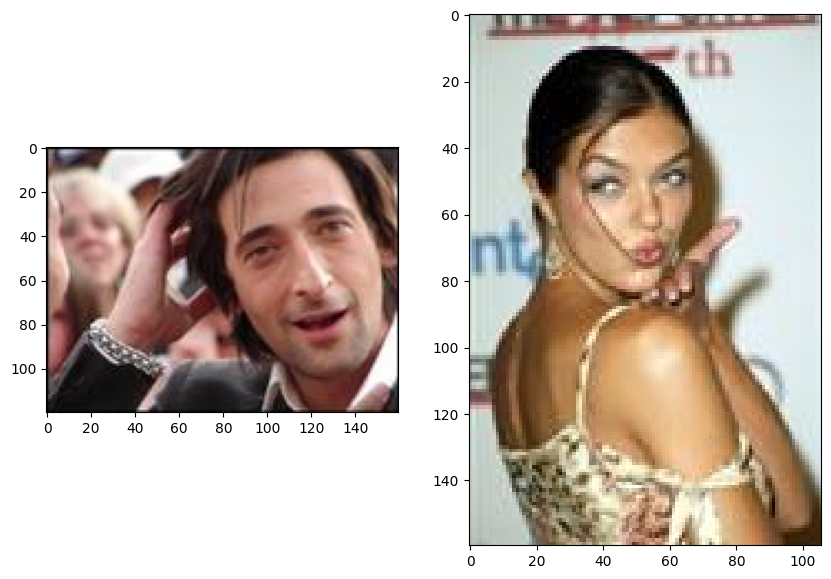

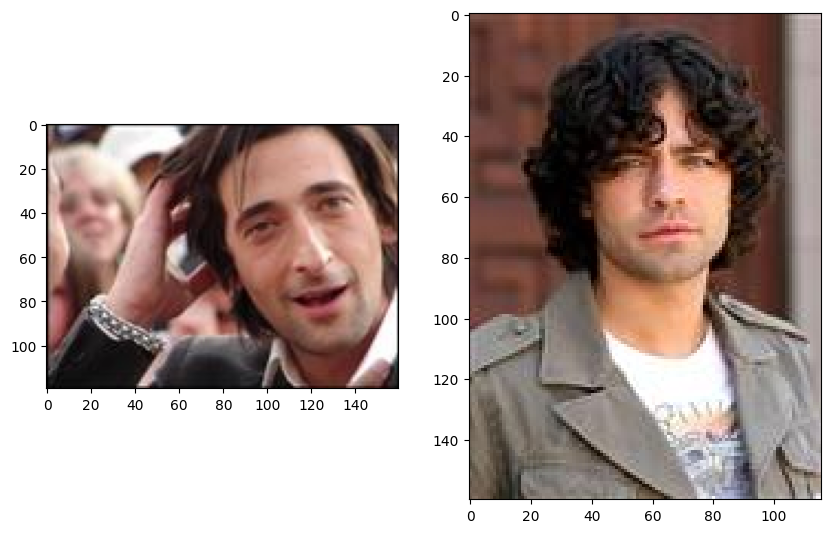

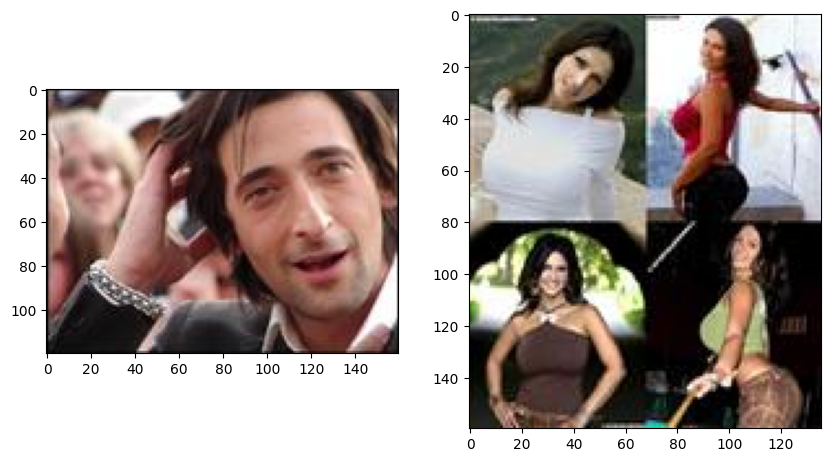

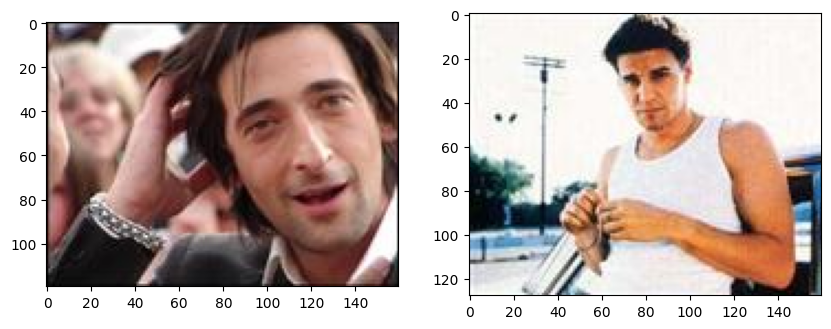

In [ ]:
retrieval(loaded_mobilenet['paths'], '/content/thumbnails_features_deduped_publish/adrien brody/101.jpg', tree_mobilenet, mobilenet, mobilenet_v2.preprocess_input,2,loaded_mobilenet)

### Example 2

1/1 [==============================] - 0s 81ms/step
Distanza dalla query: 97.584470142688
Percorso dell'immagine: /content/vip/50 cent/200.jpg
Distanza dalla query: 98.2620019718426
Percorso dell'immagine: /content/vip/adam sandler/181.jpg
[23704  6758]
Similarità del coseno: 0.7008740901947021
Percorso dell'immagine: /content/vip/paul walker/99.jpg
Similarità del coseno: 0.6969606876373291
Percorso dell'immagine: /content/vip/david boreanaz/68.jpg


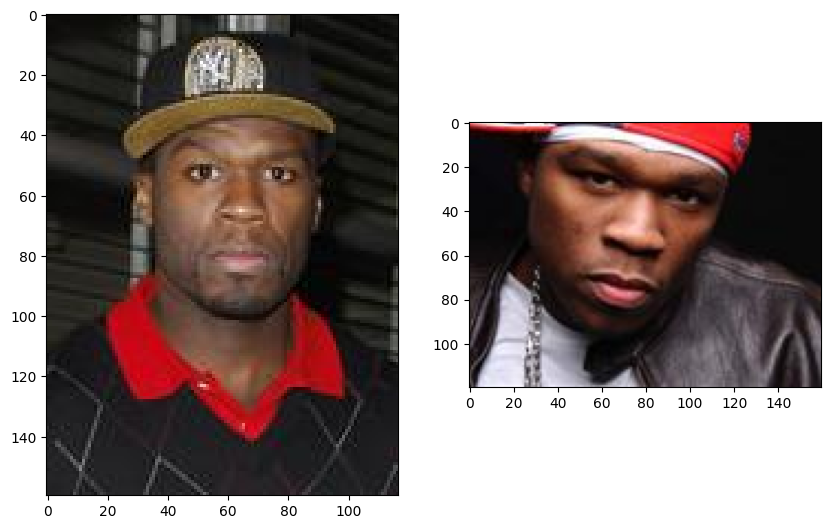

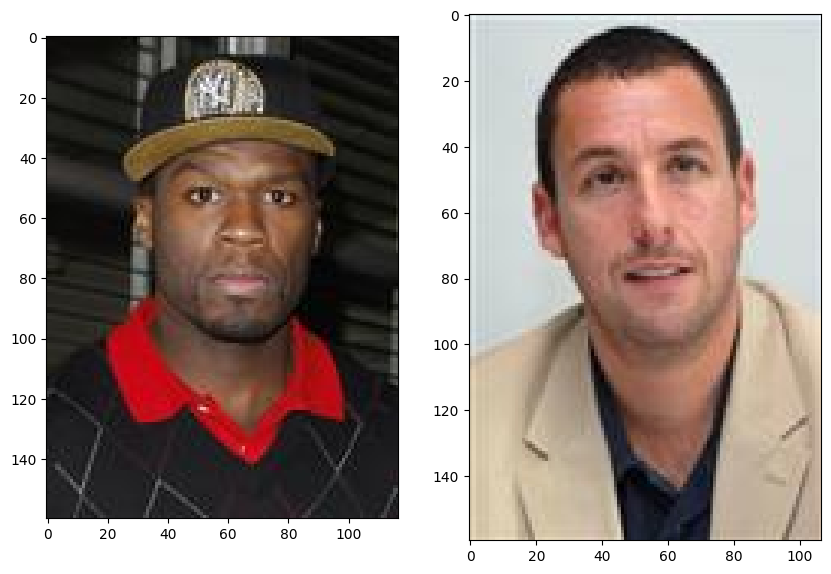

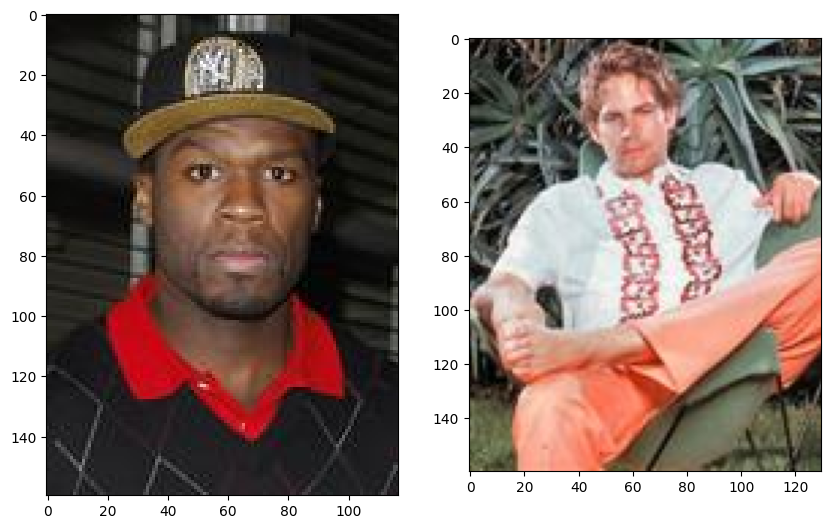

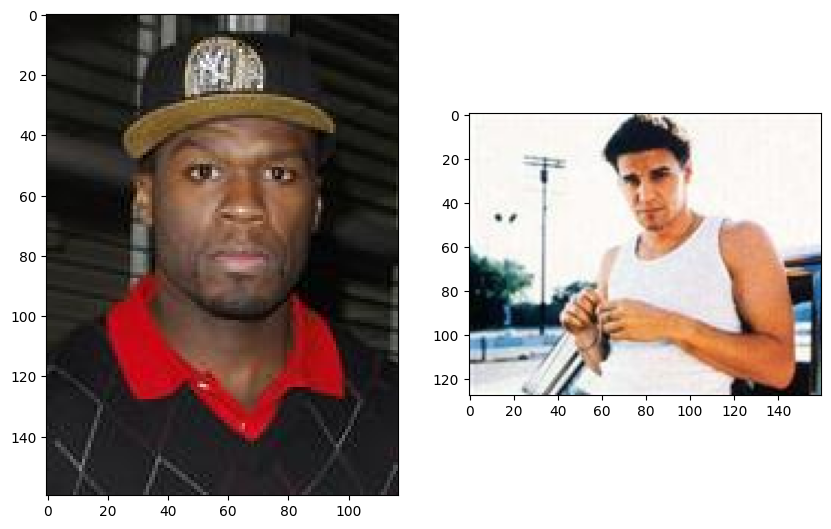

In [ ]:
retrieval(loaded_mobilenet['paths'], '/content/thumbnails_features_deduped_publish/50 cent/0.jpg', tree_mobilenet, mobilenet, mobilenet_v2.preprocess_input,2,loaded_mobilenet)

### Example 3

1/1 [==============================] - 1s 935ms/step
Distanza dalla query: 84.00097136079559
Percorso dell'immagine: /content/vip/adrienne bailon/34.jpg
Distanza dalla query: 84.53787280253091
Percorso dell'immagine: /content/vip/aishwarya rai/309.jpg
[ 335 6192]
Similarità del coseno: 0.6471128463745117
Percorso dell'immagine: /content/vip/adrienne bailon/37.jpg
Similarità del coseno: 0.6467515230178833
Percorso dell'immagine: /content/vip/cristiano ronaldo/9.jpg


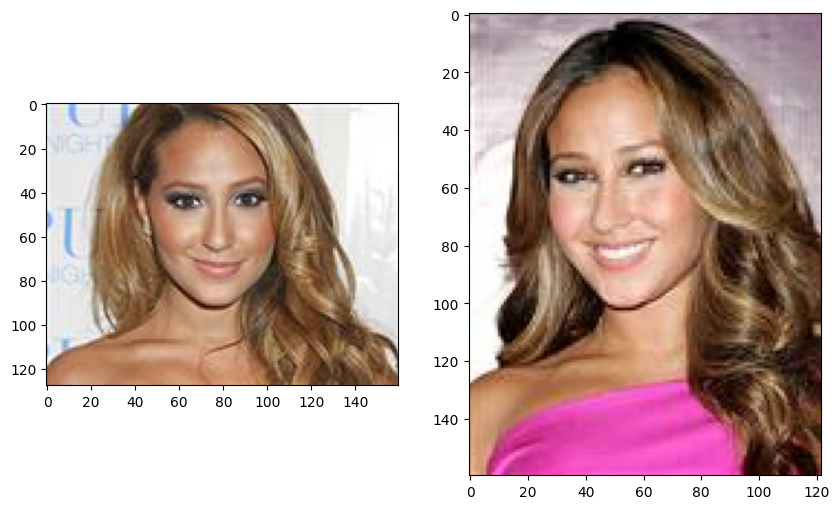

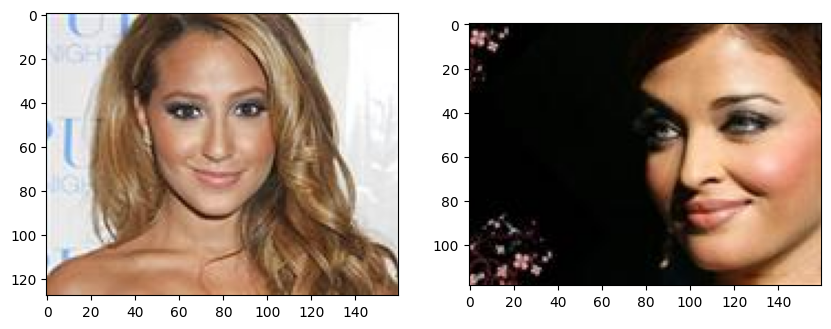

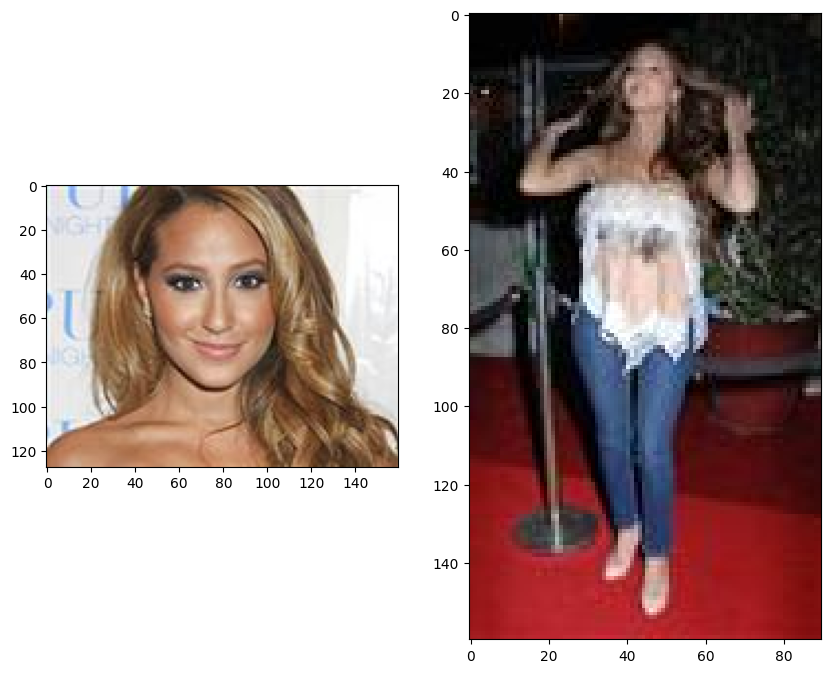

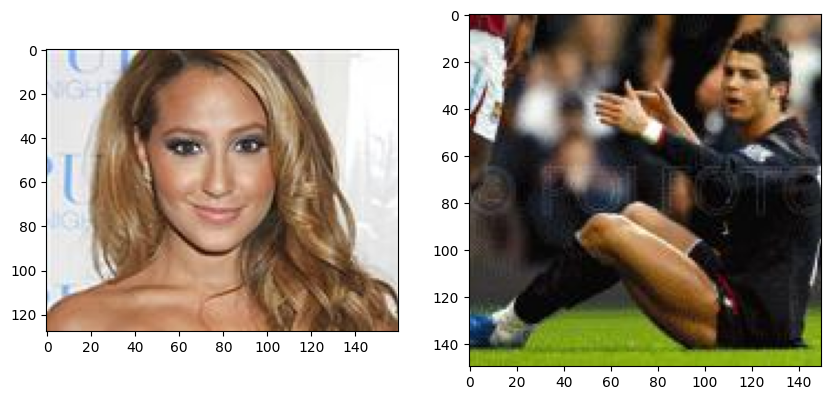

In [ ]:
retrieval(loaded_mobilenet['paths'], '/content/thumbnails_features_deduped_publish/adrienne bailon/15.jpg', tree_mobilenet, mobilenet, mobilenet_v2.preprocess_input,2,loaded_mobilenet)

# MobileNet with Cropping

In [ ]:
mobilenet = mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet',
                                     pooling='max', input_shape=(160, 160, 3))

## Cropping of dataset images

In [ ]:
detector = MTCNN()

In [ ]:
# run only for the first time
#cropped_images, paths = cropp_data(limit = 30, cropping = face_cropper_mtcnn, detector = detector)
#np.savez_compressed('cropped_images', cropped_images = cropped_images, paths = paths)
#!cp cropped_images.npz '/content/drive/MyDrive/Digital'

In [ ]:
#shutil.copyfile('/content/drive/MyDrive/Digital/cropped_images.npz', 'cropped_images.npz')

'cropped_images.npz'

In [ ]:
loaded_cropped = np.load('/content/drive/MyDrive/Digital/cropped_images.npz', allow_pickle = True)

In [ ]:
print(loaded_cropped['cropped_images'].shape)

(586,)


### Example

1/1 [==============================] - 0s 38ms/step


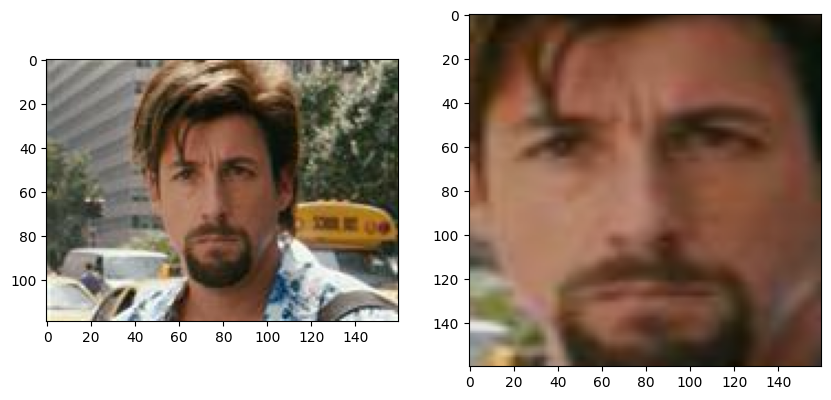

In [ ]:
# Esempio di utilizzo
image_path = "/content/drive/MyDrive/Digital/vip_drive/adam sandler/194.jpg"

# Carica l'immagine
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Esegui il ritaglio del volto
cropped_face = face_cropper_mtcnn(image_rgb, detector)

# Visualizza l'immagine ritagliata
display_img([image_rgb, cropped_face],nrow = 1, ncol = 2)
  # Rimuovi gli assi
plt.show()

## Features extraction

In [ ]:
# run only for the first time
#features_mobilenet, cropped_path_mobilenet, fail_paths_mobilenet = features_cropped_images(
#    loaded_cropped['cropped_images'],
#    loaded_cropped['paths'],
#    mobilenet,
#    prep_fun = mobilenet_v2.preprocess_input,
#    target_size = (160, 160)
#    )

/content/drive/MyDrive/Digital/vip_drive/50 cent/118.jpg
0
/content/drive/MyDrive/Digital/vip_drive/50 cent/181.jpg
/content/drive/MyDrive/Digital/vip_drive/50 cent/182.jpg
/content/drive/MyDrive/Digital/vip_drive/50 cent/200.jpg
/content/drive/MyDrive/Digital/vip_drive/50 cent/228.jpg
/content/drive/MyDrive/Digital/vip_drive/50 cent/253.jpg
/content/drive/MyDrive/Digital/vip_drive/50 cent/29.jpg
/content/drive/MyDrive/Digital/vip_drive/50 cent/337.jpg
/content/drive/MyDrive/Digital/vip_drive/50 cent/39.jpg
/content/drive/MyDrive/Digital/vip_drive/50 cent/403.jpg
/content/drive/MyDrive/Digital/vip_drive/50 cent/408.jpg
/content/drive/MyDrive/Digital/vip_drive/50 cent/472.jpg
/content/drive/MyDrive/Digital/vip_drive/50 cent/539.jpg
/content/drive/MyDrive/Digital/vip_drive/50 cent/541.jpg
/content/drive/MyDrive/Digital/vip_drive/50 cent/560.jpg
/content/drive/MyDrive/Digital/vip_drive/50 cent/637.jpg
/content/drive/MyDrive/Digital/vip_drive/50 cent/653.jpg
/content/drive/MyDrive/Digital/

In [ ]:
#np.savez_compressed('features_mobilenet_crop', features_mobilenet=features_mobilenet, cropped_path_mobilenet=cropped_path_mobilenet, fail_paths_mobilenet=fail_paths_mobilenet)

In [ ]:
#features_mobilenet_crop = np.load('/content/features_mobilenet_crop.npz')

In [ ]:
#!cp features_mobilenet_crop.npz '/content/drive/MyDrive/Digital'

In [ ]:
#shutil.copyfile('/content/drive/MyDrive/Digital/cropped_images.npz', 'cropped_images.npz')

'cropped_images.npz'

In [ ]:
features_mobilenet_crop = np.load('/content/drive/MyDrive/Digital/features_mobilenet_crop.npz', allow_pickle = True)

## Query

In [ ]:
tree_mobilenet = KDTree(features_mobilenet_crop['features_mobilenet'])

### Example 1

3/3 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 249ms/step
/content/thumbnails_features_deduped_publish/adrien brody/101.jpg
0
1/1 [==============================] - 0s 67ms/step
[[481 145]]
/content/drive/MyDrive/Digital/vip_drive/lisa rinna/64.jpg
65.59036305265352
/content/drive/MyDrive/Digital/vip_drive/chris martin/29.jpg
65.89690485489446
[145 481]
Similarità del coseno: 0.78466796875
Percorso dell'immagine: /content/drive/MyDrive/Digital/vip_drive/chris martin/29.jpg
Similarità del coseno: 0.78466796875
Percorso dell'immagine: /content/drive/MyDrive/Digital/vip_drive/lisa rinna/64.jpg


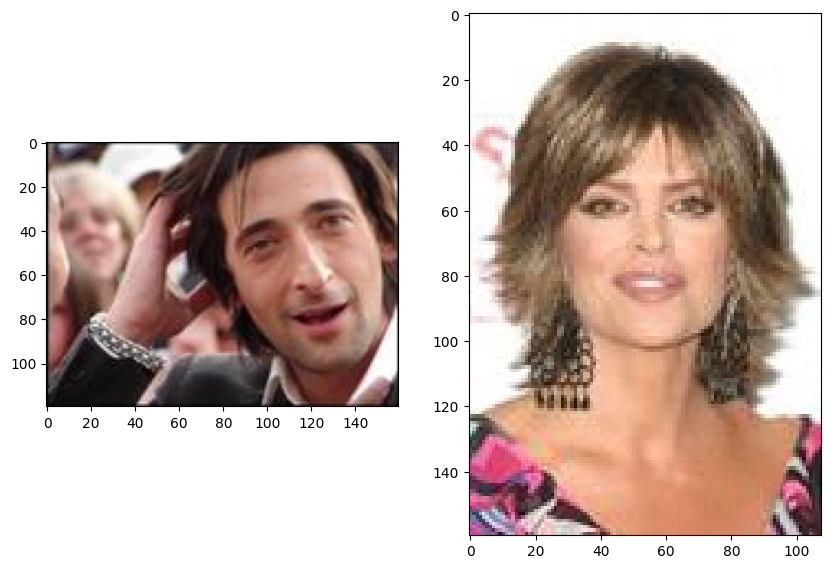

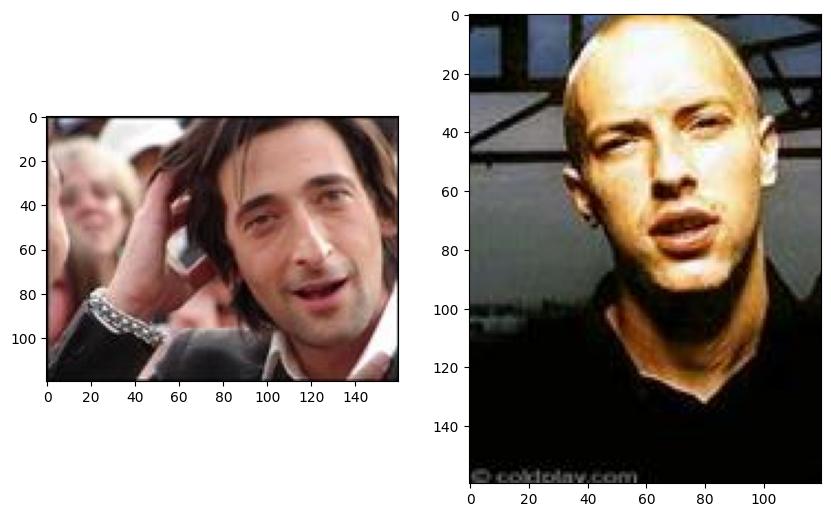

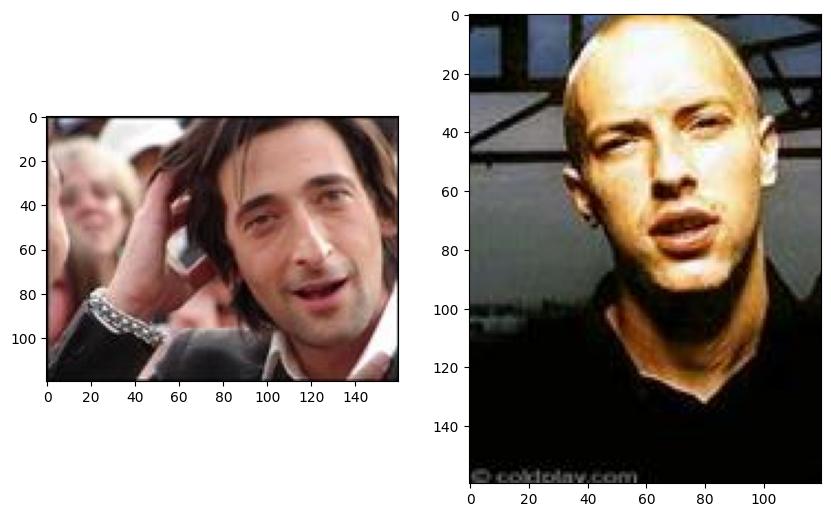

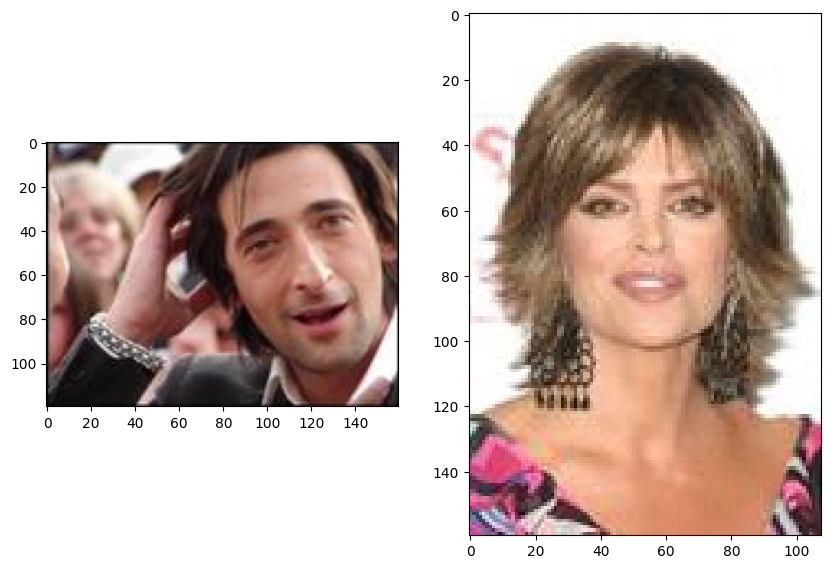

In [ ]:
detector = MTCNN()
retrieval_cropping(
    features_mobilenet_crop['cropped_path_mobilenet'],
    '/content/thumbnails_features_deduped_publish/adrien brody/101.jpg',
    tree_mobilenet,
    mobilenet,
    prep_function = mobilenet_v2.preprocess_input,
    num_image = 2,
    target_size = (160, 160),
    cropping = face_cropper_mtcnn,
    detector = detector
    )

### Example 2

1/1 [==============================] - 0s 194ms/step


1/1 [==============================] - 0s 206ms/step
/content/thumbnails_features_deduped_publish/50 cent/0.jpg
0
1/1 [==============================] - 0s 42ms/step
[[  8 554]]
/content/drive/MyDrive/Digital/vip_drive/50 cent/39.jpg
63.80185462953915
/content/drive/MyDrive/Digital/vip_drive/mos def/42.jpg
63.88208272796102
[560   8]
Similarità del coseno: 0.7890625
Percorso dell'immagine: /content/drive/MyDrive/Digital/vip_drive/mos def/60.jpg
Similarità del coseno: 0.78125
Percorso dell'immagine: /content/drive/MyDrive/Digital/vip_drive/50 cent/39.jpg


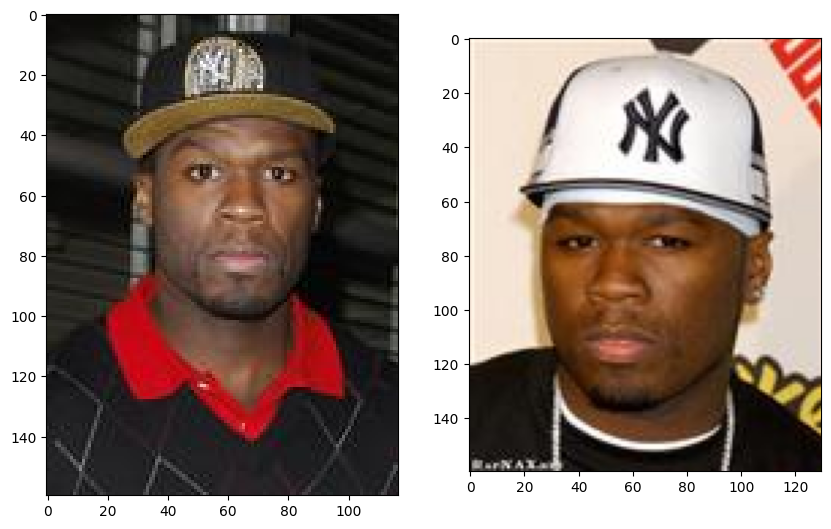

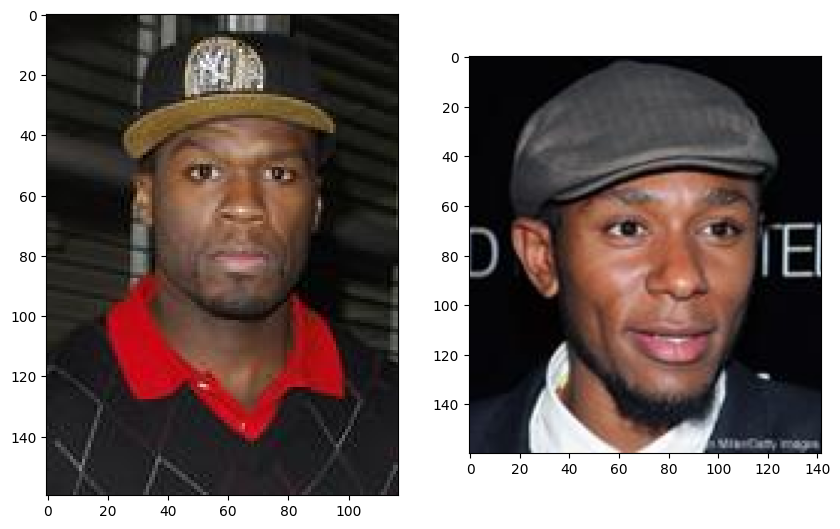

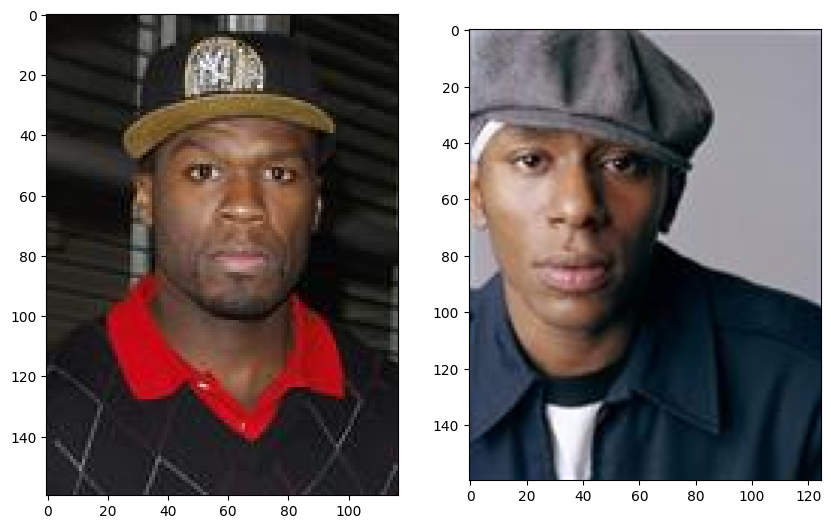

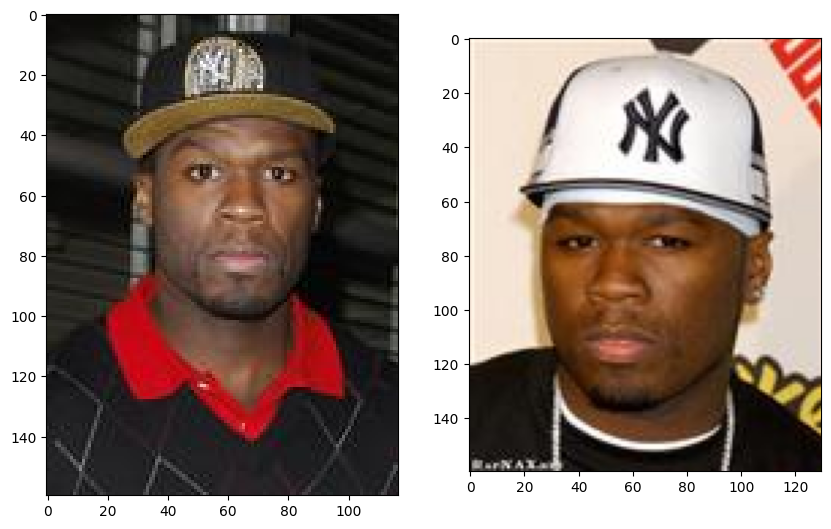

In [ ]:
detector = MTCNN()
retrieval_cropping(
    features_mobilenet_crop['cropped_path_mobilenet'],
    '/content/thumbnails_features_deduped_publish/50 cent/0.jpg',
    tree_mobilenet,
    mobilenet,
    prep_function = mobilenet_v2.preprocess_input,
    num_image = 2,
    target_size = (160, 160),
    cropping = face_cropper_mtcnn,
    detector = detector
    )

### Example 3

1/1 [==============================] - 0s 354ms/step
/content/thumbnails_features_deduped_publish/adam sandler/129.jpg
0
1/1 [==============================] - 0s 103ms/step
[[523 112]]
/content/drive/MyDrive/Digital/vip_drive/matt mullenweg/68.jpg
69.8237607271175
/content/drive/MyDrive/Digital/vip_drive/bow wow/59.jpg
71.5819861567533
[454 504]
Similarità del coseno: 0.75
Percorso dell'immagine: /content/drive/MyDrive/Digital/vip_drive/laura bush/28.jpg
Similarità del coseno: 0.7490234375
Percorso dell'immagine: /content/drive/MyDrive/Digital/vip_drive/margaret thatcher/70.jpg


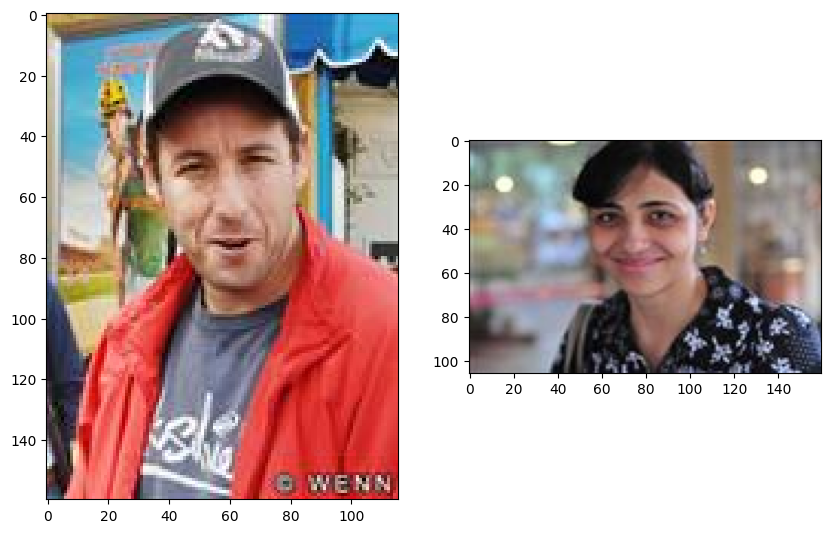

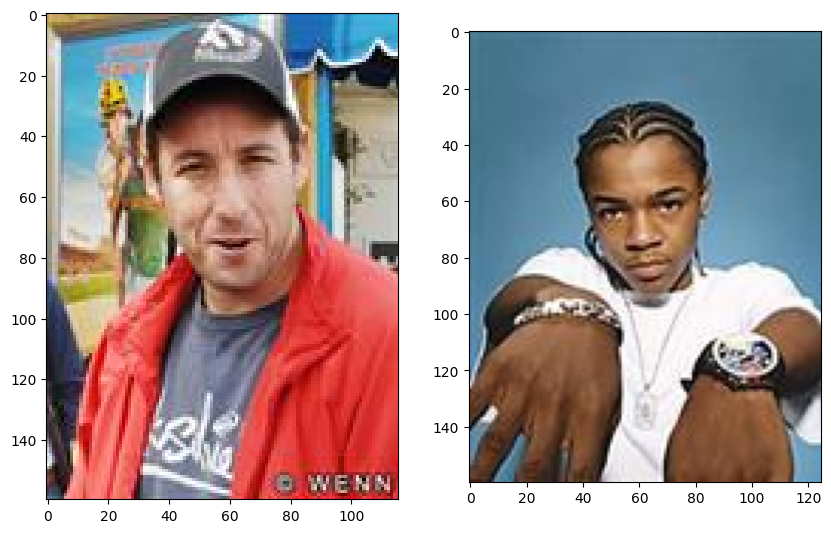

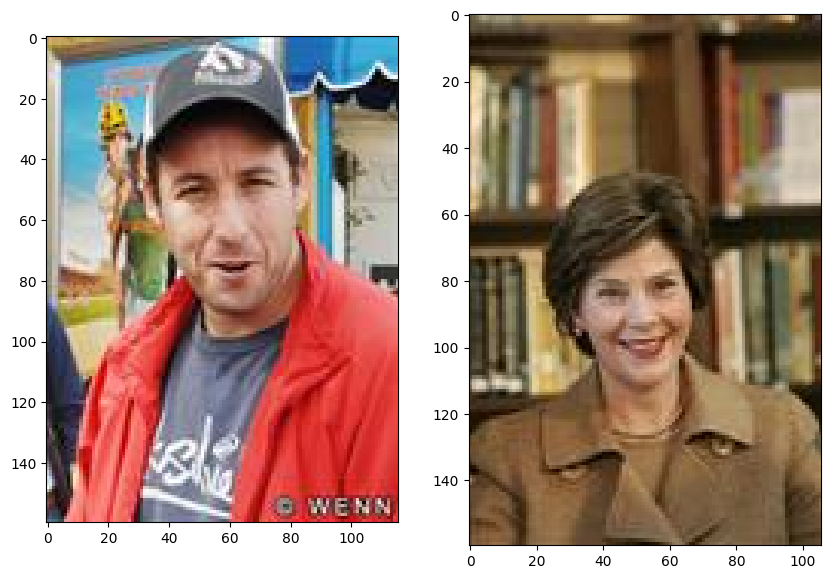

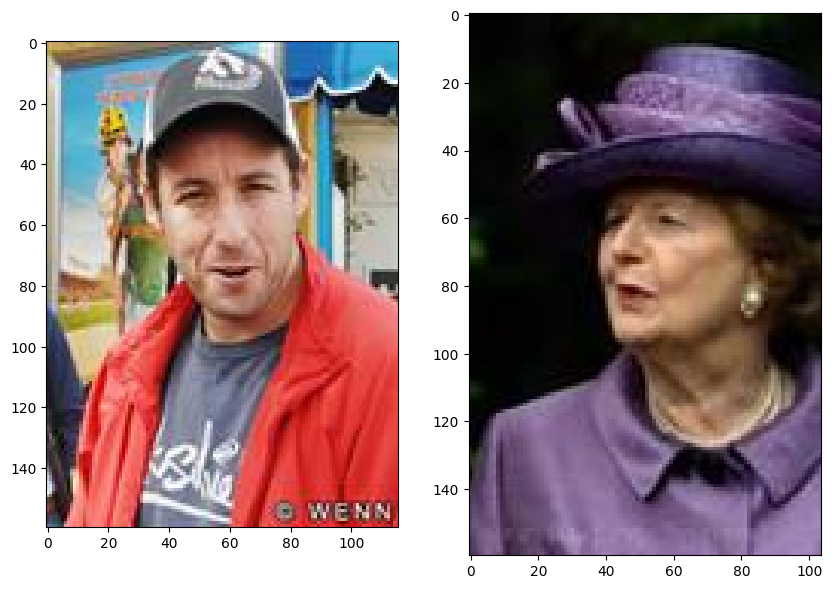

In [ ]:
detector = MTCNN()
retrieval_cropping(
    features_mobilenet_crop['cropped_path_mobilenet'],
    '/content/thumbnails_features_deduped_publish/adam sandler/129.jpg',
    tree_mobilenet,
    mobilenet,
    prep_function = mobilenet_v2.preprocess_input,
    num_image = 2,
    target_size = (160, 160),
    cropping = face_cropper_mtcnn,
    detector = detector
    )